# 1. 


## Multivariate Normal Distribution

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.lines as lines
import matplotlib.colors as colors

import scipy.stats 

import sklearn.discriminant_analysis
import sklearn.naive_bayes
import sklearn.linear_model

from dataclasses import dataclass
from typing import Tuple


%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (20, 10)
RESOLUTION = 100


### Density of 1D Normal Distribution
#### Shift

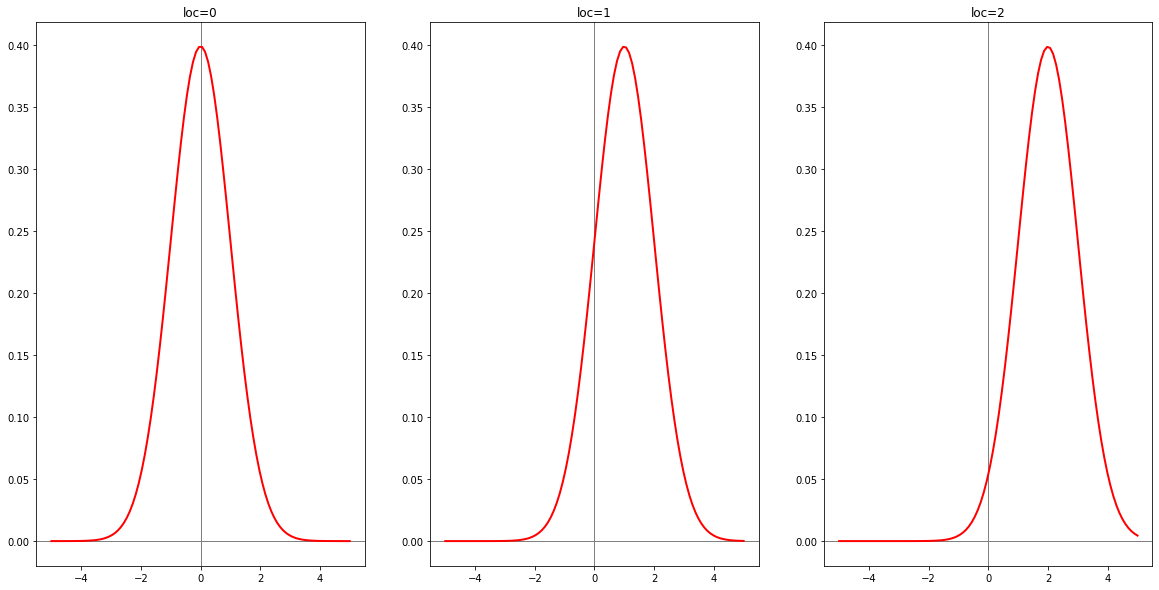

In [2]:
params = [0, 1, 2]
fig, axs = plt.subplots(1, len(params))

for ax, param in zip(axs, params):
    x = np.linspace(-5, 5, RESOLUTION)
    y = scipy.stats.norm.pdf(x, loc=param, scale=1)
    #                           ^ loc parameter shifts the distribution
    
    # draws x=0 and y=0 lines
    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)
    # draws density of the normal distribution
    ax.plot(x, y, linewidth=2, color='red')

    # puts the "loc=X" on top
    ax.set_title(f'loc={param}')


#### Scale

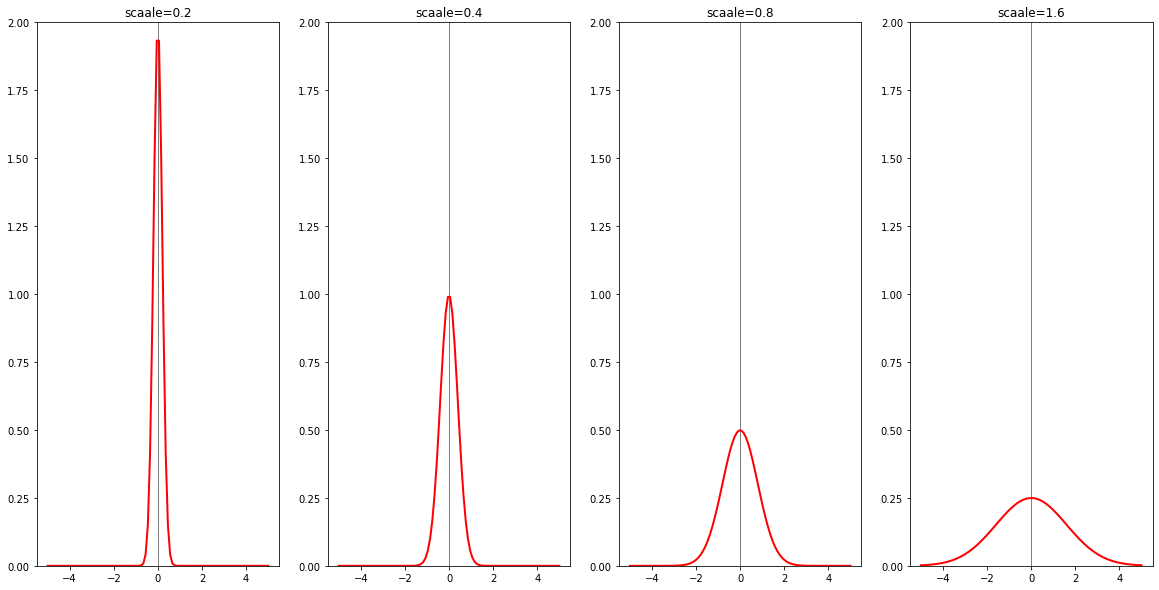

In [3]:
params = [0.2, 0.4, 0.8,1.6]
fig, axs = plt.subplots(1, len(params))

for ax, param in zip(axs, params):
    x = np.linspace(-5, 5, RESOLUTION)
    y = scipy.stats.norm.pdf(x, loc=0, scale=param)
    #                                  ^ scale parameter scales the distribution
    
    # forces the y axes to be the same for all subplots
    ax.set_ylim([0, 2])
    # draws x=0 and y=0 lines
    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)
    # draws density of the normal distribution
    ax.plot(x, y, linewidth=2, color='red')

    # puts the "loc=X" on top
    ax.set_title(f'scaale={param}')

### How to fit data to the distribution (in this case normal)

In [4]:
# this generates random data
np.random.seed(0)
data = np.random.randn(100,1)

# we can scale the data -> multiply them
true_scale = 0.5

# we can shift the data -> add constant
true_shift = 2

data = data*true_scale + true_shift

#### Using the library (the easy way)

In [5]:
predicted_shift, predicted_scale = scipy.stats.norm.fit(data)
print(f"predicted shift = {predicted_shift}")
print(f"predicted scale = {predicted_scale}")

predicted shift = 2.0299040077672426
predicted scale = 0.5039411223582898


#### Using linear algebra
i.e. find the 'best' parameters (shift and scale) to maximalize probability of the data.

The trick is to optimize the logarithm of a probability of data given parameters of the distribution. 
The N-D derivation can be found in http://jrmeyer.github.io/machinelearning/2017/08/18/mle.html .

In [6]:
predicted_shift = np.mean(data)
predicted_scale = np.std(data)
print(f"predicted shift = {predicted_shift}")
print(f"predicted scale = {predicted_scale}")

predicted shift = 2.0299040077672426
predicted scale = 0.5039411223582898


#### Using iterative aproaches 
e.g. gradient descent

you need 'tensorflow' library to run the example

In [7]:
try:
    import tensorflow as tf
    import tensorflow_probability as tfp
    tf_loaded = True
except:
    tf_loaded = False
    
if tf_loaded:
    # Defines the model
    class MyModel(tf.keras.Model):
        def __init__(self):
            super().__init__()
            self.mu = tf.Variable(0., dtype=tf.float32, trainable=True, name='shift')
            self.log_sigma = tf.Variable(1., dtype=tf.float32, trainable=True)
        
        def call(self, inputs):
            sigma = tf.math.exp(self.log_sigma)
            d = tfp.distributions.Normal(loc=self.mu, scale=sigma)
            return d.log_prob(inputs)
    
    # Creates the model
    model = MyModel()
    
    # Defines the optimization algorithm (SGD is obsolete)
    optimizer =  tf.optimizers.SGD(learning_rate=0.001)
    
    # Steps in the descent
    for step in range(100):
        
        # This library provides automatic derivative using GradientTape
        with tf.GradientTape() as tape:
            log_probabilities = model(data)
            loss = tf.reduce_sum(log_probabilities)
            loss = -loss
            
        # computes the derivative and moves the pramameters in correct direction
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    print(f"predicted shift = {model.mu.numpy()}")
    print(f"predicted scale = {np.exp(model.log_sigma.numpy())}")


2023-03-07 11:26:26.390508: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-07 11:26:26.390532: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: tumpji2
2023-03-07 11:26:26.390537: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: tumpji2
2023-03-07 11:26:26.390614: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.86.1
2023-03-07 11:26:26.390627: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.86.1
2023-03-07 11:26:26.390630: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.86.1
2023-03-07 11:26:26.390809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

predicted shift = 2.0299038887023926
predicted scale = 0.5039415955543518


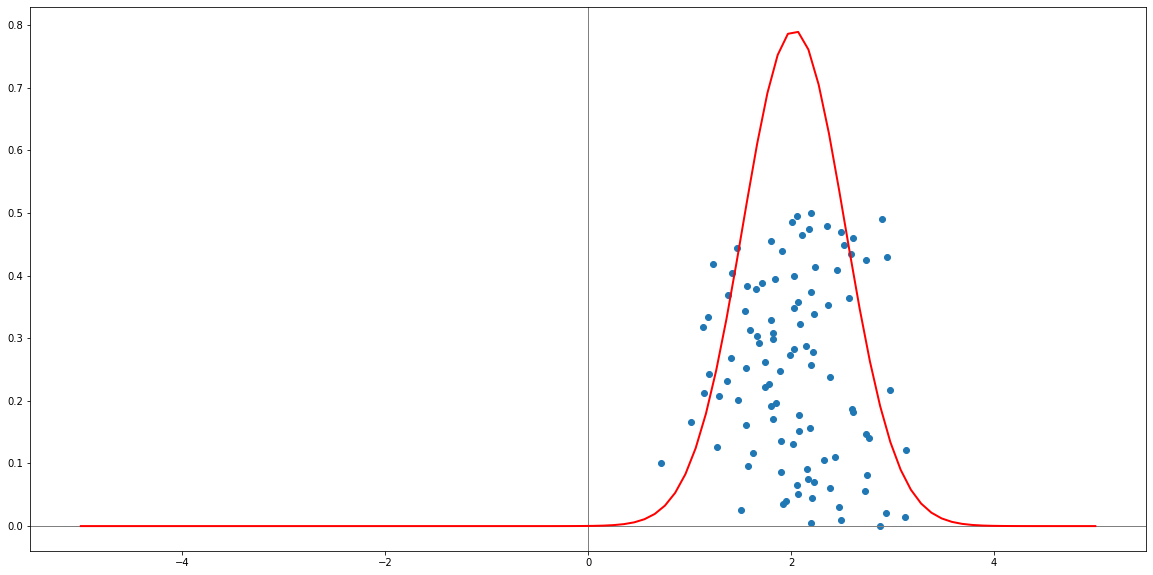

In [8]:
fig, ax = plt.subplots()

x = np.linspace(-5, 5, RESOLUTION)
y = scipy.stats.norm.pdf(x, loc=predicted_shift, scale=predicted_scale)
    
# draws x=0 and y=0 lines
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

# draws density of the normal distribution
ax.plot(x, y, linewidth=2, color='red')

#ax.scatter(data, np.random.rand(len(data)) * 0.5)
ax.scatter(data, np.linspace(0, 0.5, len(data)))

### Density of N-D distribution

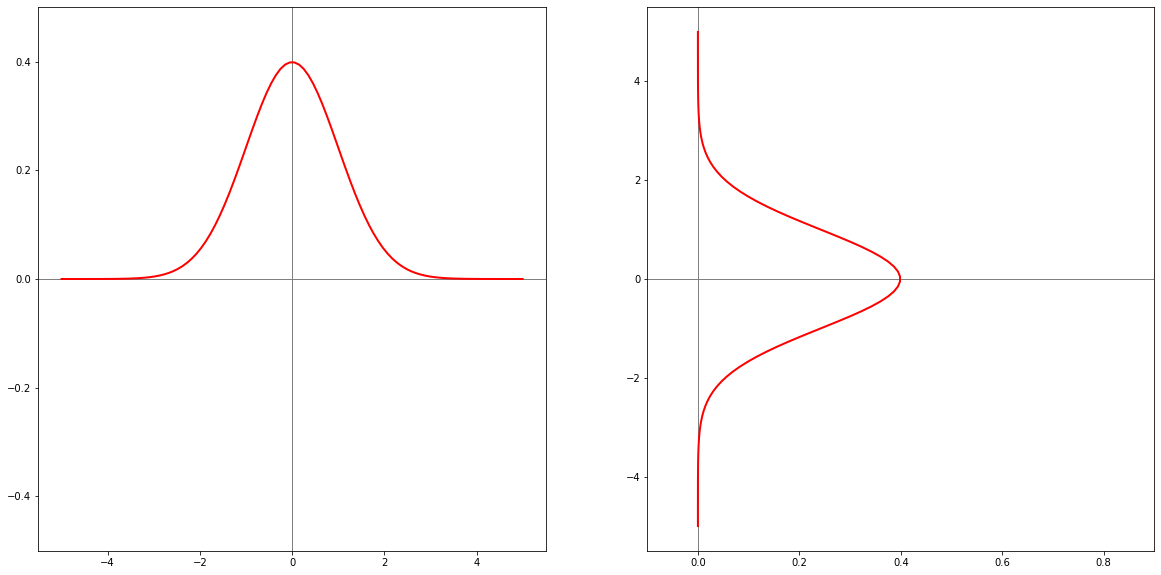

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)

x = np.linspace(-5, 5, RESOLUTION)
y = scipy.stats.norm.pdf(x, loc=0, scale=1)

ax1.set_ylim([-0.5,0.5])
ax2.set_xlim([-0.1,0.9])

# draws x=0 and y=0 lines
ax1.axvline(c='grey', lw=1)
ax1.axhline(c='grey', lw=1)
ax2.axvline(c='grey', lw=1)
ax2.axhline(c='grey', lw=1)

# draws density of the normal distribution
ax1.plot(x, y, linewidth=2, color='red')

base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)  

# draws density of the normal distribution
ax2.plot(x, y, linewidth=2, color='red', transform = rot+base)

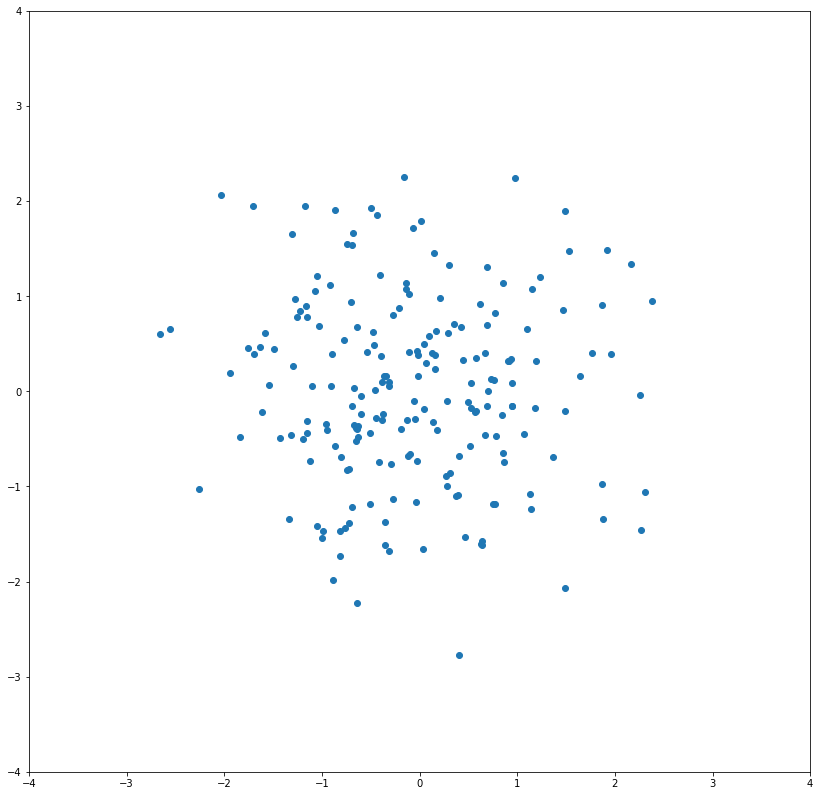

In [10]:
matplotlib.rcParams['figure.figsize'] = (14, 14)
# create new dataset
np.random.seed(0)
data = scipy.stats.multivariate_normal.rvs(
    mean = [0,0], cov=[[1, 0],[0, 1]], size=200)


# draw dataset
fig, ax = plt.subplots()
ax.set_ylim([-4, 4])
ax.set_xlim([-4, 4])

ax.scatter(*data.T)

### The Empirical Rule
For all normal distributions, 68.2% of the observations will appear within plus or minus one standard deviation of the mean; 95.4% of the observations will fall within +/- two standard deviations; and 99.7% within +/- three standard deviations. 

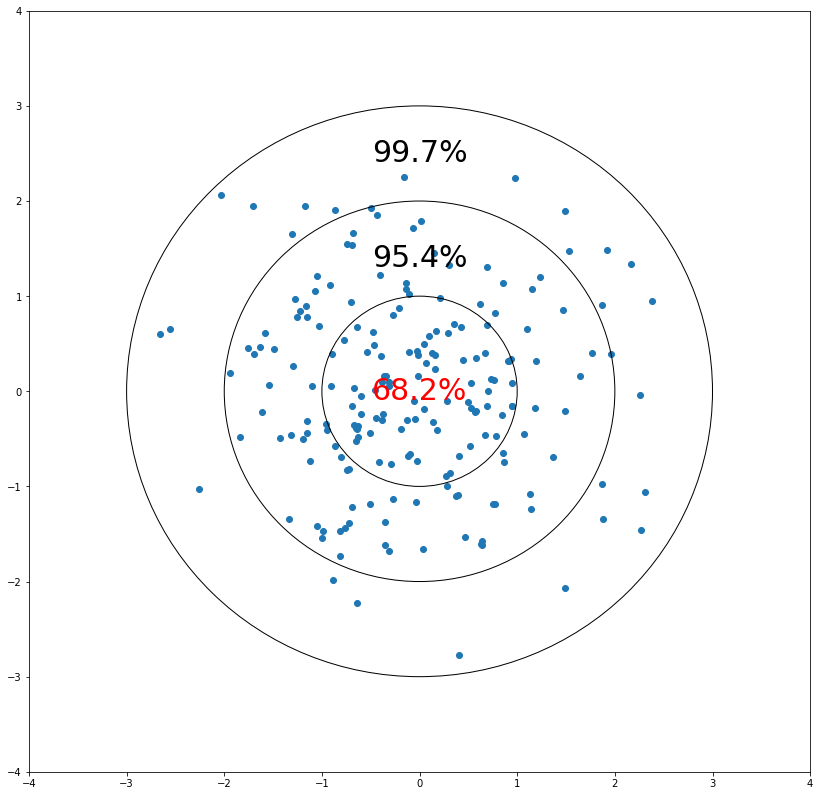

In [11]:
for stddev in [1,2,3]: 
    ax.add_artist(
        plt.Circle( (0, 0), stddev, fill = False)
    )

ax.text(0.0, 0.0, '68.2%', fontsize=30, va='center', ha='center', color='red')
ax.text(0.0, 1.4, '95.4%', fontsize=30, va='center', ha='center')
ax.text(0.0, 2.5, '99.7%', fontsize=30, va='center', ha='center')
fig

In [12]:
print(np.cov(data.T))
print('vs.')
print(np.eye(2))

[[ 0.99655338 -0.0427989 ]
 [-0.0427989   0.96228824]]
vs.
[[1. 0.]
 [0. 1.]]


### Transformations

In [13]:
np.random.seed(0)
data = scipy.stats.multivariate_normal.rvs(
    mean = [0,0], cov=[[1, 0],[0, 1]], size=200)

transformation_matrix = np.array([
    [-0.5, 0.5],
    [0, 1]
])

data = data @ transformation_matrix.T

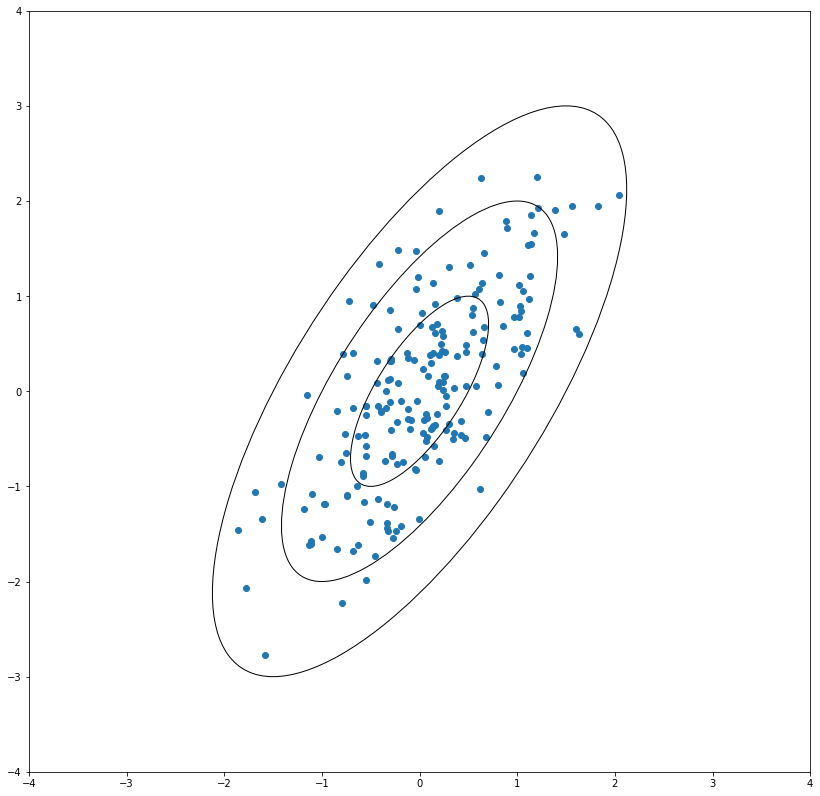

In [14]:
def add_ellipse(ax, cov=None, data=None, transformation=None, mean=None, show_stddev = 1., **kwargs):
    ''' adds ellipse to graph '''
    if mean is None: mean = np.zeros((2, 1))
    if transformation is not None: cov = transformation @ transformation.T
    if data is not None: cov = np.cov(data.T)
    if cov is None: cov = np.eye(2)
        
    correlation = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ellipse = Ellipse((0, 0),  width=np.sqrt(1 + correlation) * 2, height=np.sqrt(1 - correlation) * 2,
                      fill=False, **kwargs)

    transf = transforms.Affine2D().rotate_deg(45) \
        .scale(np.sqrt(cov[0,0]) * show_stddev, np.sqrt(cov[1,1]) * show_stddev) \
        .translate(*mean)

    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)
    
# draw dataset
fig, ax = plt.subplots()
ax.set_ylim([-4, 4])
ax.set_xlim([-4, 4])

ax.scatter(*data.T)
    
add_ellipse(ax, transformation=transformation_matrix, show_stddev=1)
add_ellipse(ax, transformation=transformation_matrix, show_stddev=2)
add_ellipse(ax, transformation=transformation_matrix, show_stddev=3)

### Fitting the data

Predicted covariance matrix:
[[0.51110986 0.50254357]
 [0.50254357 0.96228824]]

True covariance matrix:
[[0.5 0.5]
 [0.5 1. ]]

Predicted mean: [0.04346601 0.01491402]


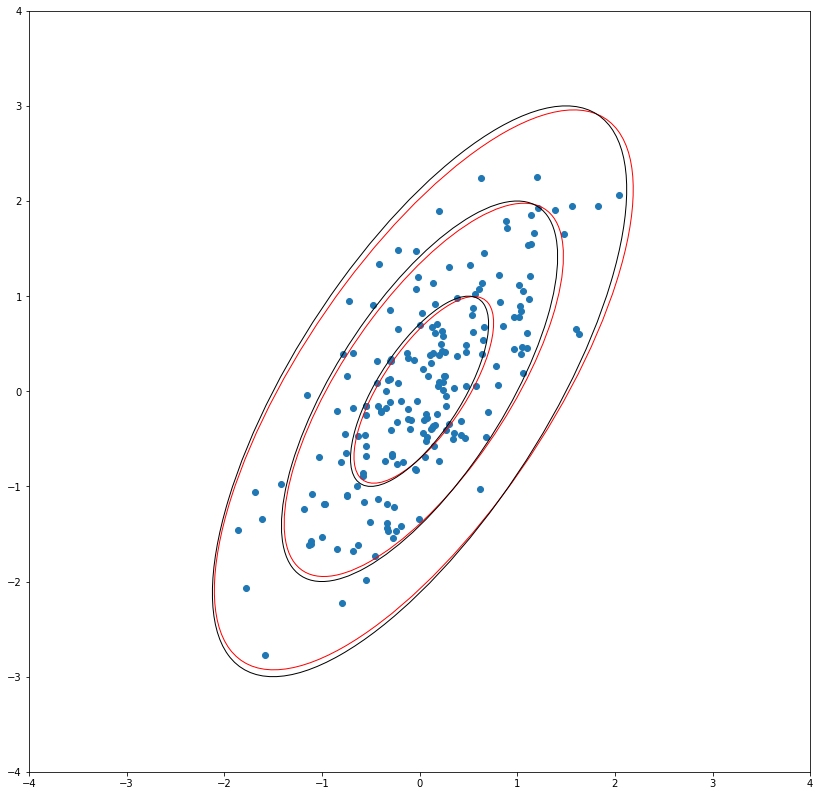

In [15]:
print(f"Predicted covariance matrix:\n{np.cov(data.T)}")
print()
print(f"True covariance matrix:\n{transformation_matrix @ transformation_matrix.T}")
print()
print(f'Predicted mean: {np.mean(data, axis=0)}')


# draw dataset
fig, ax = plt.subplots()
ax.set_ylim([-4, 4])
ax.set_xlim([-4, 4])

ax.scatter(*data.T)

cov = np.cov(data.T)
mean = np.mean(data, axis=0)
    
add_ellipse(ax, mean=mean, cov=cov, show_stddev=1, color='red')
add_ellipse(ax, mean=mean, cov=cov, show_stddev=2, color='red')
add_ellipse(ax, mean=mean, cov=cov, show_stddev=3, color='red')

add_ellipse(ax, transformation=transformation_matrix, show_stddev=1)
add_ellipse(ax, transformation=transformation_matrix, show_stddev=2)
add_ellipse(ax, transformation=transformation_matrix, show_stddev=3)

#### Dependency on the size of dataset

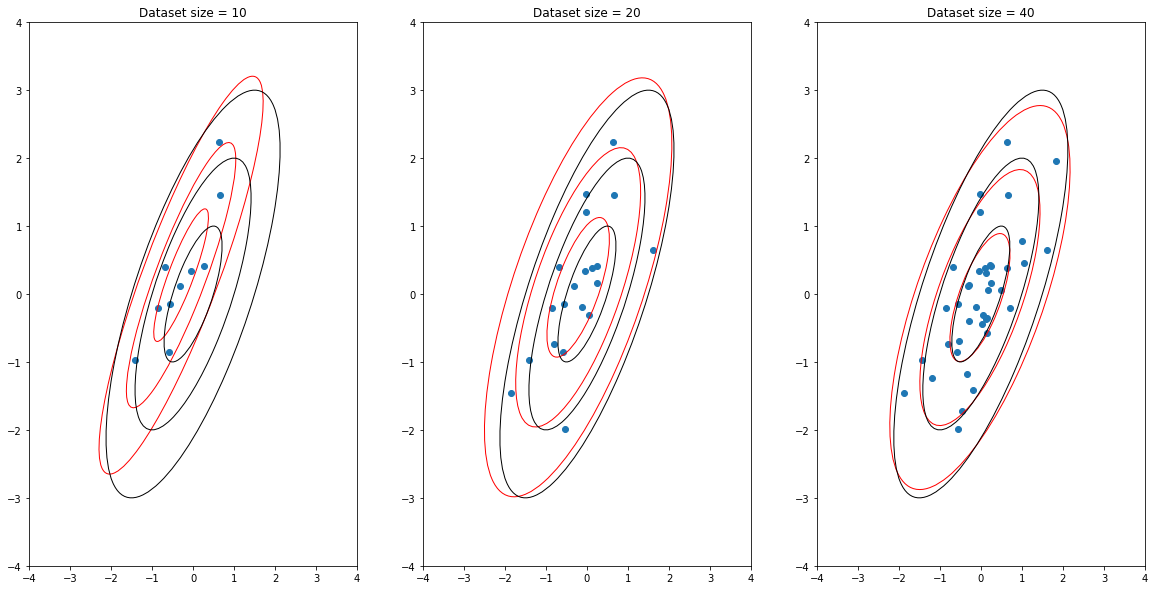

In [16]:
sizes = [10, 20, 40]
# draw dataset
fig, axs = plt.subplots(1, len(sizes), figsize=(20,10))

for ax, size in zip(axs, sizes): 
    ax.set_ylim([-4, 4])
    ax.set_xlim([-4, 4])

    ax.scatter(*data[:size].T)

    cov = np.cov(data[:size].T)
    mean = np.mean(data[:size], axis=0)

    add_ellipse(ax, mean=mean, cov=cov, show_stddev=1, color='red')
    add_ellipse(ax, mean=mean, cov=cov, show_stddev=2, color='red')
    add_ellipse(ax, mean=mean, cov=cov, show_stddev=3, color='red')
    
    add_ellipse(ax, transformation=transformation_matrix, show_stddev=1)
    add_ellipse(ax, transformation=transformation_matrix, show_stddev=2)
    add_ellipse(ax, transformation=transformation_matrix, show_stddev=3)
    
    ax.set_title(f'Dataset size = {size}')

## Classification

In [17]:
# samples per class
N1 = 10
N2 = 40
# probability of class
P1 = 0.5
P2 = 0.5

mean1 = np.array([-2, -2])
mean2 = np.array([2, 2])

cov1 = cov2 = np.eye(2)

np.random.seed(1)
data1 = scipy.stats.multivariate_normal.rvs(mean=mean1, size=N1)
data2 = scipy.stats.multivariate_normal.rvs(mean=mean2, size=N2)

Text(3.0, -1.0, 'Second class')

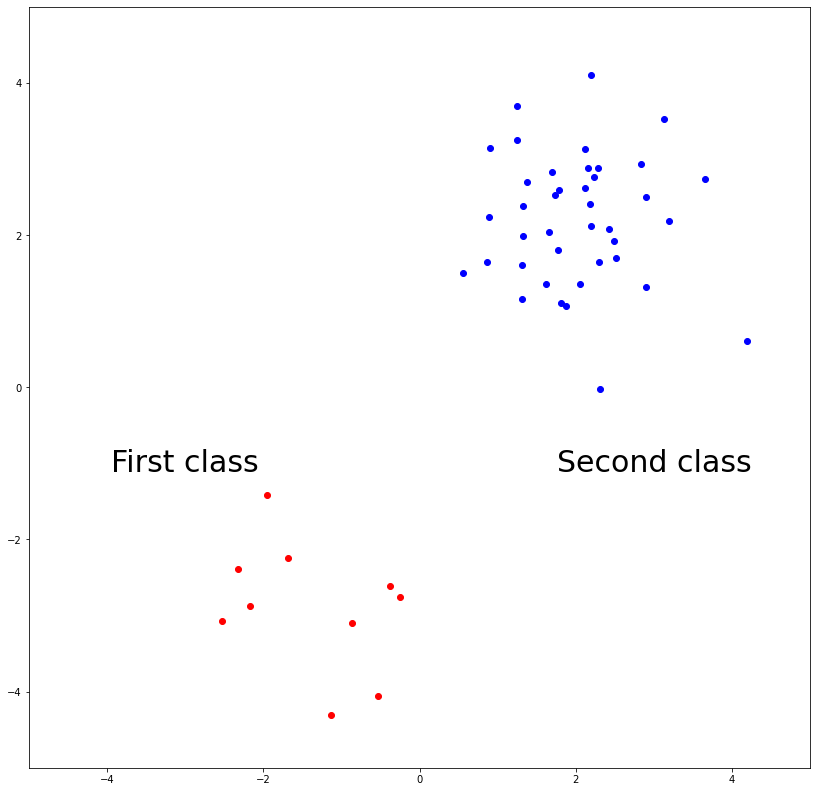

In [18]:
# draw dataset
fig, ax = plt.subplots()
ax.set_ylim([-5, 5])
ax.set_xlim([-5, 5])

ax.scatter(*data1.T, color='red')
ax.scatter(*data2.T, color='blue')

ax.text(-3.0, -1.0, 'First class', fontsize=30, va='center', ha='center')
ax.text(3.0,  -1.0, 'Second class', fontsize=30, va='center', ha='center')

### How to select the best decision line?

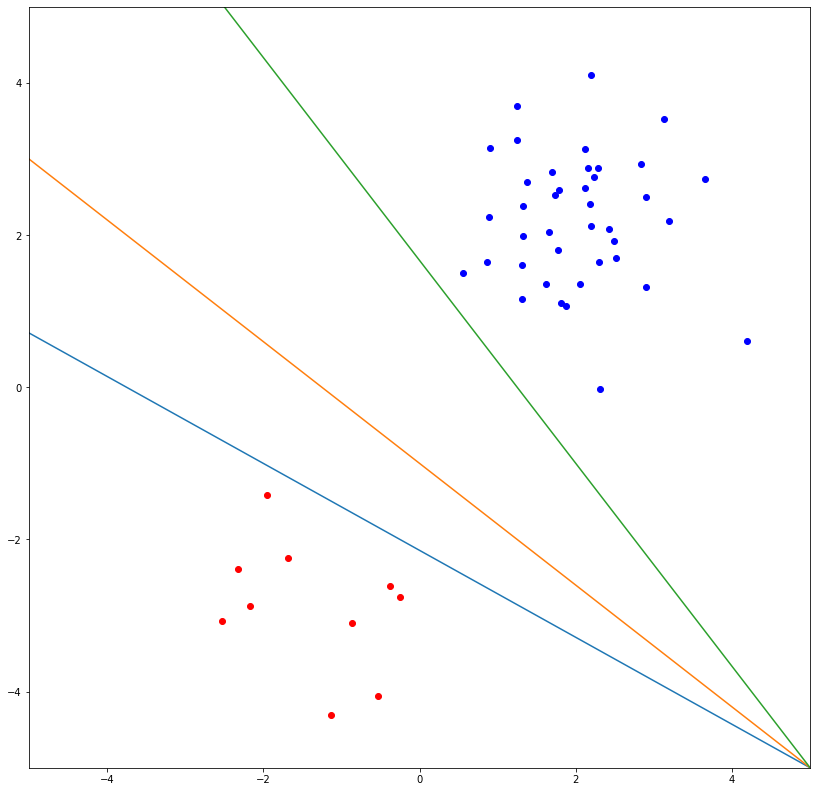

In [19]:
fig, ax = plt.subplots()
ax.set_ylim([-5, 5])
ax.set_xlim([-5, 5])

ax.scatter(*data1.T, color='red')
ax.scatter(*data2.T, color='blue')

for d in [30, 20, 10]:
    plt.plot([-d, 5], [15, -5])

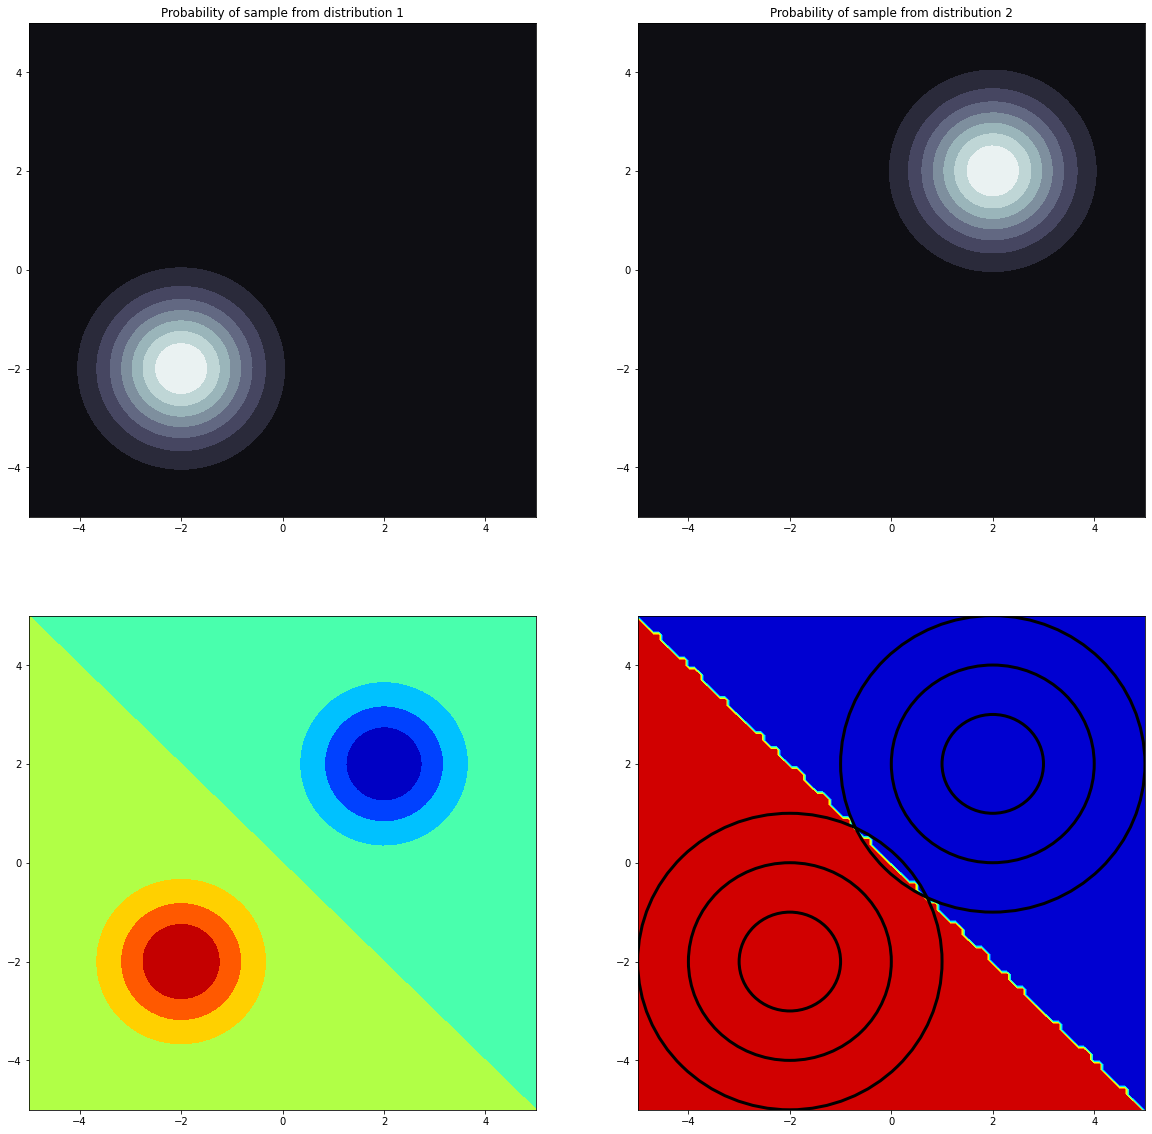

In [20]:
xspace = np.linspace(-5, 5, RESOLUTION)
yspace = np.linspace(-5, 5, RESOLUTION)
xmesh, ymesh = np.meshgrid(xspace, yspace)

predicted_mean1 = np.mean(data1, axis=0)
predicted_mean2 = np.mean(data2, axis=0)

predicted_cov1 = np.cov(data1.T)
predicted_cov2 = np.cov(data2.T)



# compute probabilities of samples given class
probability_of_sample1 = scipy.stats.multivariate_normal.pdf(
    np.dstack((xmesh, ymesh)), mean=mean1, cov=cov1)  * P1
probability_of_sample2 = scipy.stats.multivariate_normal.pdf(
    np.dstack((xmesh, ymesh)), mean=mean2, cov=cov2)  * P2

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,20))

ax1.contourf(xspace, yspace, probability_of_sample1, cmap=plt.cm.bone)
ax1.set_title('Probability of sample from distribution 1')
ax2.contourf(xspace, yspace, probability_of_sample2, cmap=plt.cm.bone)
ax2.set_title('Probability of sample from distribution 2')

ax3.contourf(xspace, yspace, probability_of_sample1-probability_of_sample2, cmap='jet')

ax4.contourf(xspace, yspace, probability_of_sample1 > probability_of_sample2, cmap='jet')
#                            ^ the classification is a comparison of probabilities
#                              i.e. selecting the class that generated the sample with higher probability
ax4.set_ylim([-5, 5])
ax4.set_xlim([-5, 5])

for i in [1,2,3]:
    add_ellipse(ax4, mean=mean1, cov=cov1, show_stddev=i, color='black', linewidth=3)
    add_ellipse(ax4, mean=mean2, cov=cov2, show_stddev=i, color='black', linewidth=3)

### Real world is not always so nice

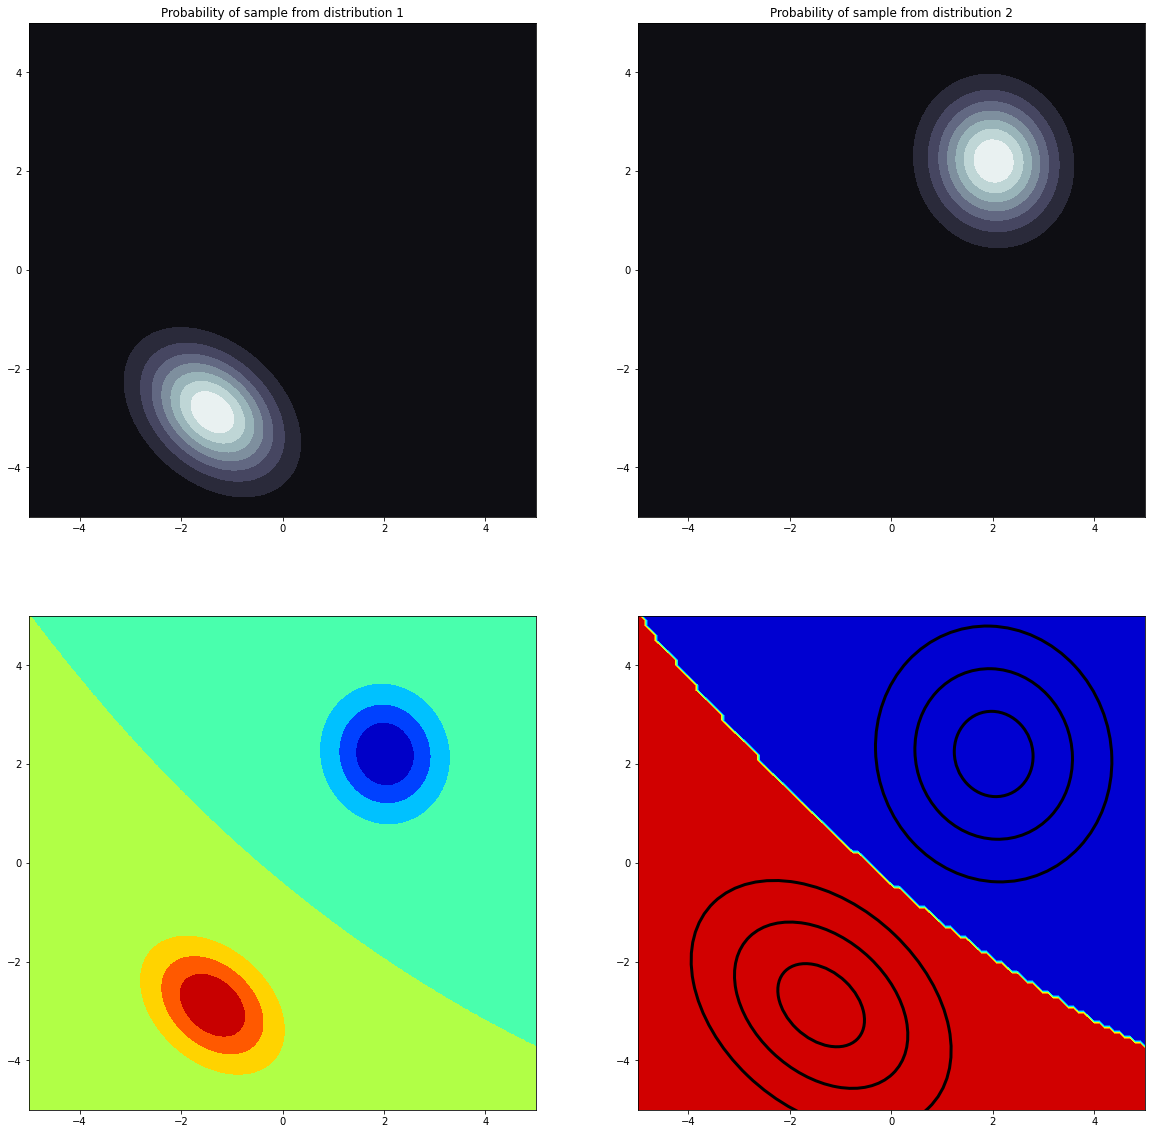

In [21]:
probability_of_sample1 = scipy.stats.multivariate_normal.pdf(
    np.dstack((xmesh, ymesh)), mean=predicted_mean1, cov=predicted_cov1) * P1

probability_of_sample2 = scipy.stats.multivariate_normal.pdf(
    np.dstack((xmesh, ymesh)), mean=predicted_mean2, cov=predicted_cov2) * P2


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,20))

ax1.contourf(xspace, yspace, probability_of_sample1, cmap=plt.cm.bone)
ax1.set_title('Probability of sample from distribution 1')
ax2.contourf(xspace, yspace, probability_of_sample2, cmap=plt.cm.bone)
ax2.set_title('Probability of sample from distribution 2')

#norm=colors.SymLogNorm(linthresh=0.001, vmin=-2, vmax=2, clip=True)
ax3.contourf(xspace, yspace, probability_of_sample1-probability_of_sample2, cmap='jet')

ax4.contourf(xspace, yspace, probability_of_sample1 > probability_of_sample2, cmap='jet')
ax4.set_ylim([-5, 5])
ax4.set_xlim([-5, 5])

for i in [1,2,3]:
    add_ellipse(ax4, mean=predicted_mean1, cov=predicted_cov1, show_stddev=i, color='black', linewidth=3)
    add_ellipse(ax4, mean=predicted_mean2, cov=predicted_cov2, show_stddev=i, color='black', linewidth=3)

### Quadrics
In the case of two multivariate gaussian distributions, the decision line is always some quadric.
Let's look at them.

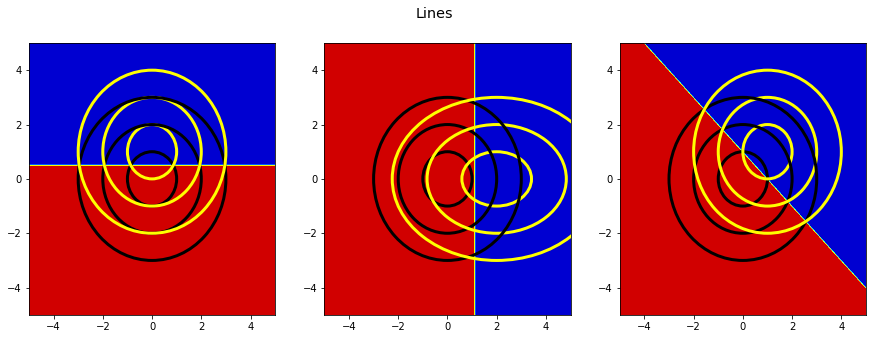

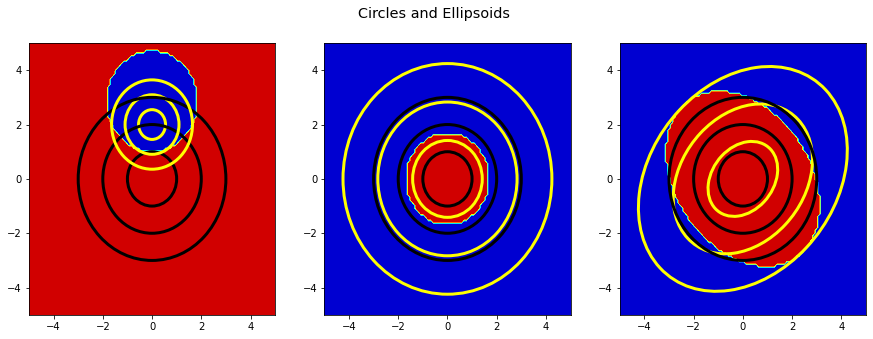

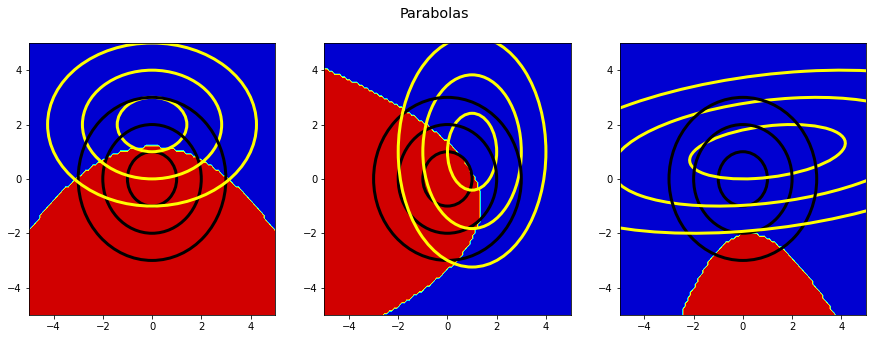

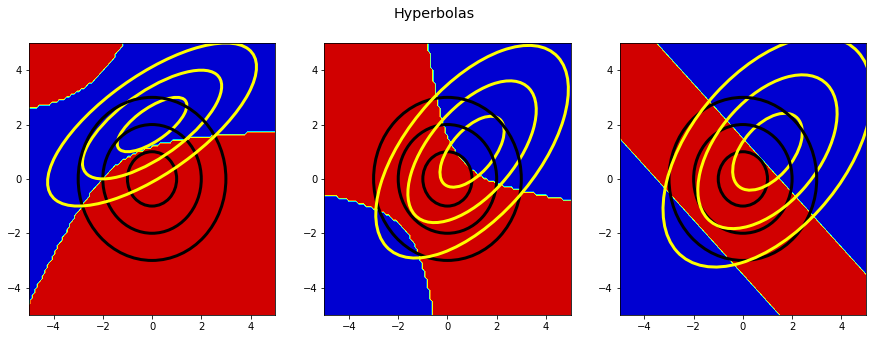

In [22]:
mean1 = np.array([0, 0])
cov1 = np.eye(2)

probability_of_sample1 = scipy.stats.multivariate_normal.pdf(
    np.dstack((xmesh, ymesh)), mean=mean1, cov=cov1) 

def draw_plane(ax, mean2, cov2, P2=0.5):
    probability_of_sample2 = scipy.stats.multivariate_normal.pdf(
        np.dstack((xmesh, ymesh)), mean=mean2, cov=cov2) 

    P1 = 1 - P2

    ax.contourf(xspace, yspace, probability_of_sample1 * P1 > probability_of_sample2 * P2, cmap='jet')
    ax.set_ylim([-5, 5])
    ax.set_xlim([-5, 5])

    for i in [1,2,3]:
        add_ellipse(ax, mean=mean1, cov=cov1, show_stddev=i, color='black', linewidth=3)
        add_ellipse(ax, mean=mean2, cov=cov2, show_stddev=i, color='yellow', linewidth=3)
        
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("Lines", fontsize="x-large")
draw_plane(ax1, [0, 1], cov1)
draw_plane(ax2, [2, 0], np.array([[2, 0],[0, 1]]))
draw_plane(ax3, [1, 1], cov1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("Circles and Ellipsoids", fontsize="x-large")
draw_plane(ax1, [0, 2], cov1*0.3)
draw_plane(ax2, [0, 0], cov1*2)
draw_plane(ax3, [0, 0], np.array([[2, 0.5],[0.5, 1.9]]), P2=0.2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("Parabolas", fontsize="x-large")
draw_plane(ax1, [0, 2], np.array([[2, 0],[0, 1]]))
draw_plane(ax2, [1, 1], np.array([[1, 0],[0, 2]]))
draw_plane(ax3, [1, 1], np.array([[10, 1],[1, 1]]), P2=0.98)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("Hyperbolas", fontsize="x-large")
draw_plane(ax1, [0, 2], np.array([[2, 1],[1, 1]]))
draw_plane(ax2, [1, 1], np.array([[1.7, 1],[1, 1.7]]))
draw_plane(ax3, [1, 1], np.array([[2, 1],[1, 2]]))

# Task 1

An ornithologist studied a specific type of birds noting their behaviour.
However, during the study, he realized that he was watching two very similar species.
He wants to correct his notes. 
Unfortunately, he cannot go back because the birds are already gone.

Fortunately, the notes contain the number of beeps the bird has done during the study,
and he discovered that number of beeps can be modeled using Poisson distribution.

The number of beeps the first species made is distributed with parameter lambda=2
while the number of beeps the second bird made with parameter lambda=4.


- Task 1: [1b] Make a classifier using only this information (lambda=2 & lambda=4).
- Task 2: [1b] What is the expected error (probability of wrong classification)?


Handy tips:
- the distribution is discrete 
- the support is (0, \inf) but you know that no bird beeped more than 10 times
- you can use scipy.stats.geom.pdf
- Probability mass function = Probability density function for discrete distributions
- Example solution: If the bird beeped more than 7 times, it is the first species, and the probability of mistake is 11.2%

Handy links:
- https://en.wikipedia.org/wiki/Poisson_distribution

Links for implementation (you can use other libraries if you want)
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html#scipy.stats.poisson
- https://numpy.org/doc/stable/reference/generated/numpy.arange.html


In [23]:
# Task 1
beeps = np.arange(10)
print(beeps)

#prob_first  = scipy.stats.poisson.pmf(beeps, ?)
#prob_second = scipy.stats.poisson.pmf(beeps, ?)

# print(prob_first ? prob_second)

np.set_printoptions(precision=2)

[0 1 2 3 4 5 6 7 8 9]


# Bonus: How to Identify the Distribution of Your Data

1) The test for distributions - usually a bad idea
* small number of samples usually produces positive answer
* large number of samples is almost always negative 
* An example can be found at https://towardsdatascience.com/stop-testing-for-normality-dba96bb73f90

2) QQ-plot
* plots quantile of one distribution towards another one
* it needs expertise

3) Comparison of predicted densities
* usualy not precise enough, but usable
* histogram

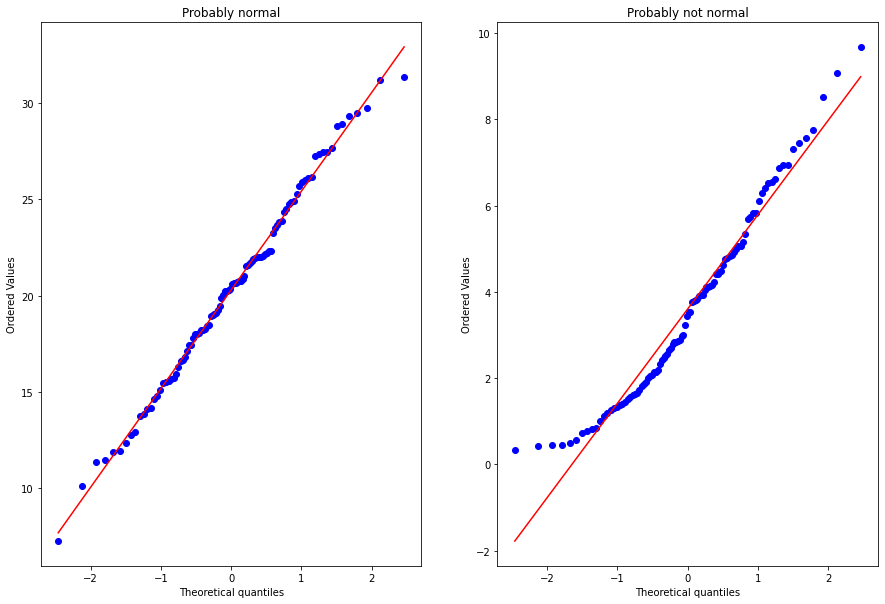

<Figure size 720x720 with 0 Axes>

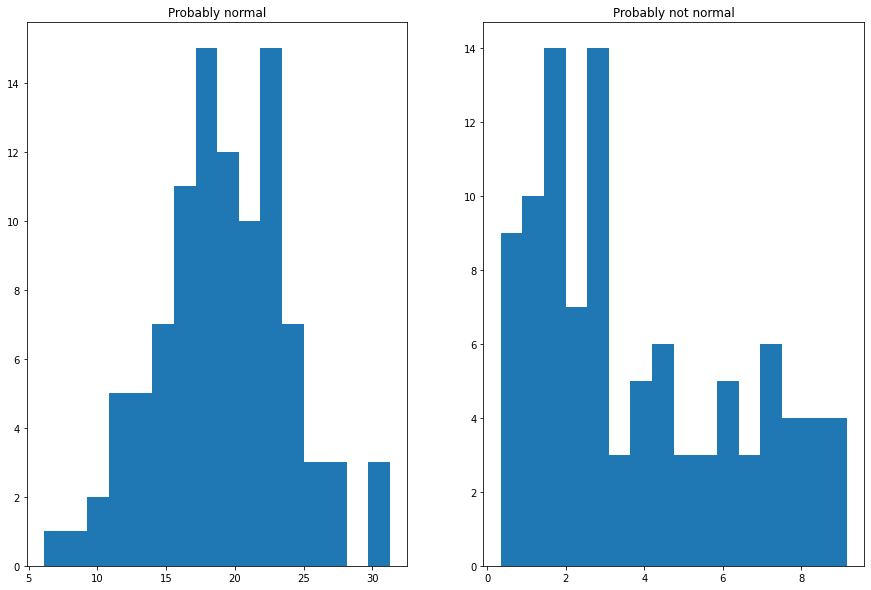

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))

# QQplots ... 
matplotlib.rcParams['figure.figsize'] = (10, 10)
np.random.seed(0)
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
scipy.stats.probplot(measurements, dist="norm", plot=ax1)
ax1.set_title('Probably normal')

plt.figure()
measurements = np.random.triangular(0, 1, 10, size=100)   
scipy.stats.probplot(measurements, dist="norm", plot=ax2)
ax2.set_title('Probably not normal')


# Histograms ...
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
ax1.hist(measurements, bins=16)
ax1.set_title('Probably normal')

measurements = np.random.triangular(0, 1, 10, size=100)   
ax2.hist(measurements, bins=16)
ax2.set_title('Probably not normal')
None

# Scikit-learn package
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-download-auto-examples-classification-plot-classifier-comparison-py

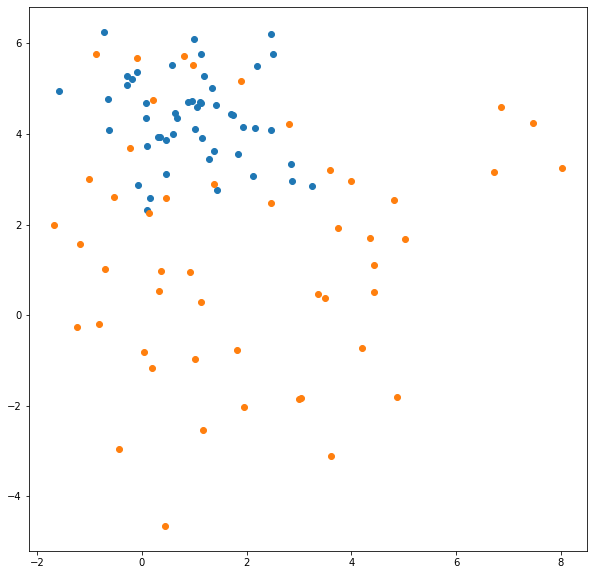

In [25]:
# This will create training data
import sklearn.datasets

X, Y = sklearn.datasets.make_blobs(
    n_samples=100,
    cluster_std=[1.0, 2.5],
    random_state=0,
    centers=2
)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(*X[Y==0].T)
ax.scatter(*X[Y==1].T)


xspace = np.linspace(-2, 8, RESOLUTION)
yspace = np.linspace(-5, 7, RESOLUTION)
xmesh, ymesh = np.meshgrid(xspace, yspace)

testdata = np.vstack([np.ravel(xmesh), np.ravel(ymesh)]).T

## How to use sklearn:

Text(0.5, 1.0, 'Quadratic Discriminant Analysis')

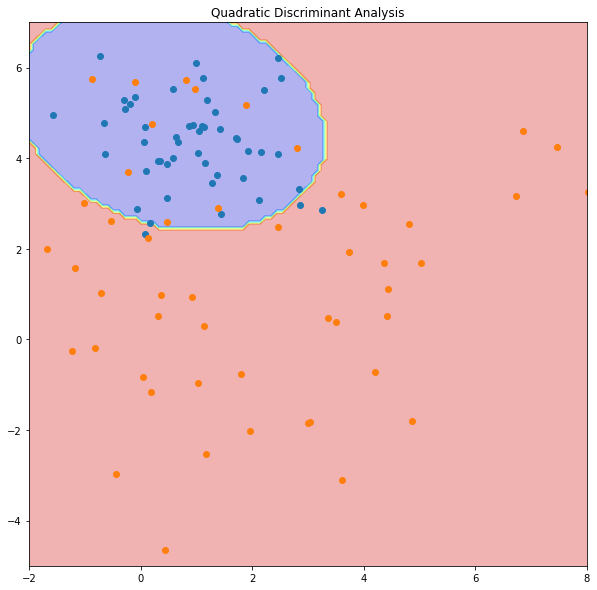

In [26]:
# CREATE THE CLASSIFIER
classifier = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
# THE FIT THE CLASSIFIER 
classifier.fit(X, Y)
# PREDICT
# the classifier accepts data with (no. data, no. features) shape
predictions = classifier.predict(testdata)

# show the results
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_xlim([-2, 8])
ax.set_ylim([-5, 7])
ax.contourf(xspace, yspace, predictions.reshape(xmesh.shape), cmap='jet', alpha=0.3)
ax.scatter(*X[Y==0].T)
ax.scatter(*X[Y==1].T)
ax.set_title('Quadratic Discriminant Analysis')

Text(0.5, 1.0, 'Gaussian Naive Bayes')

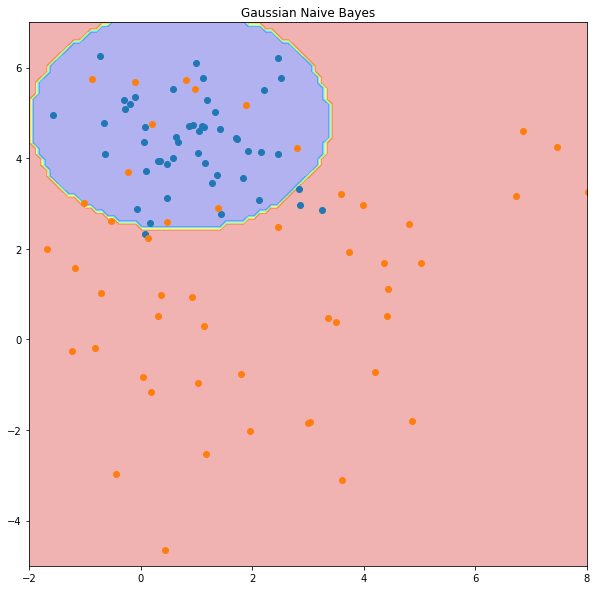

In [27]:
# CREATE THE CLASSIFIER
classifier = sklearn.naive_bayes.GaussianNB()
# THE FIT THE CLASSIFIER 
classifier.fit(X, Y)
# PREDICT
# the classifier accepts data with (no. data, no. features) shape
predictions = classifier.predict(testdata)


# show the results
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_xlim([-2, 8])
ax.set_ylim([-5, 7])
ax.contourf(xspace, yspace, predictions.reshape(xmesh.shape), cmap='jet', alpha=0.3)
ax.scatter(*X[Y==0].T)
ax.scatter(*X[Y==1].T)
ax.set_title('Gaussian Naive Bayes')

Text(0.5, 1.0, 'Linear Discriminant Analysis')

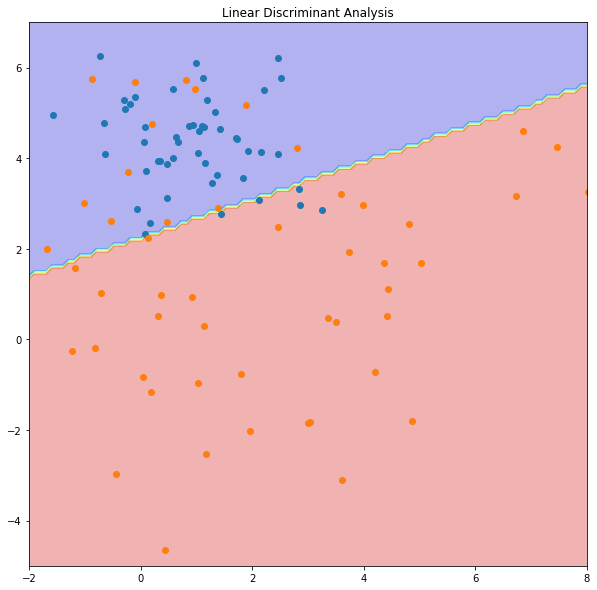

In [28]:
# CREATE THE CLASSIFIER
classifier = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
# THE FIT THE CLASSIFIER 
classifier.fit(X, Y)
# PREDICT
# the classifier accepts data with (no. data, no. features) shape
predictions = classifier.predict(testdata)


# show the results
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_xlim([-2, 8])
ax.set_ylim([-5, 7])
ax.contourf(xspace, yspace, predictions.reshape(xmesh.shape), cmap='jet', alpha=0.3)
ax.scatter(*X[Y==0].T)
ax.scatter(*X[Y==1].T)
ax.set_title('Linear Discriminant Analysis')

## Basic linear classifier - Logistic Regression
It is not regression, the name is missleading!
When the distribution is not available, you may find iterative methods usefull.

### Sigmoid function

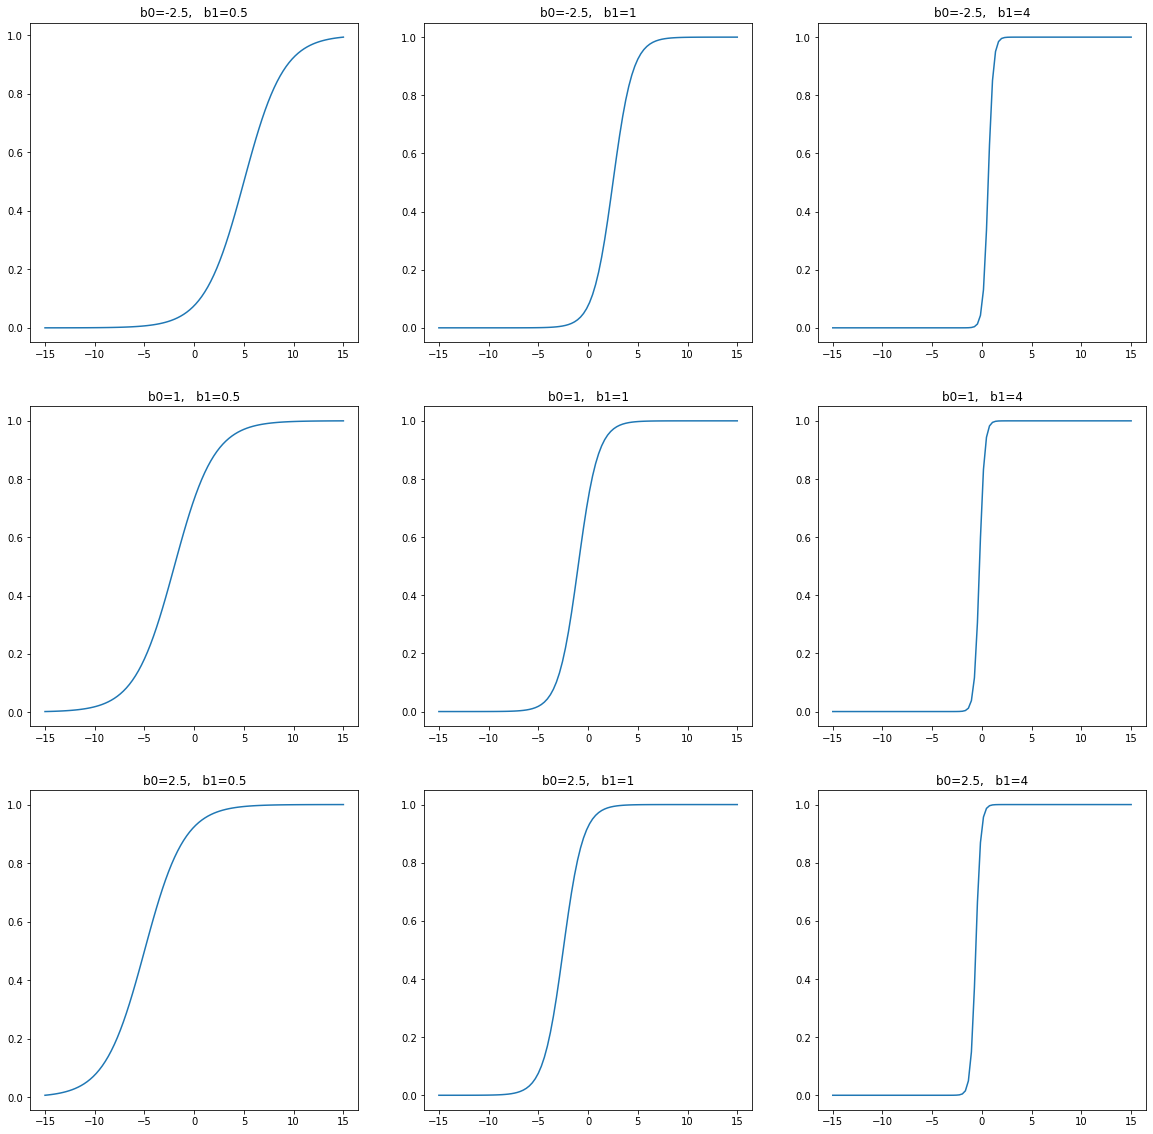

In [29]:
x = np.linspace(-15, 15, 100)

def sigmoid(x, b0, b1):
    return 1. / (1. + np.exp(-(b0 + x*b1)))

fig, axs = plt.subplots(3,3, figsize=(20,20))
for i0, b0 in enumerate([-2.5, 1, 2.5]):
    for i1, b1 in enumerate([0.5, 1, 4]):
        axs[i0, i1].plot(x, sigmoid(x, b0, b1))
        axs[i0, i1].set_title(f"b0={b0},   b1={b1}")
                 

predicted shift = 0.0
predicted slope = 1.0
predicted shift = -5.51833963394165
predicted slope = 2.596611499786377


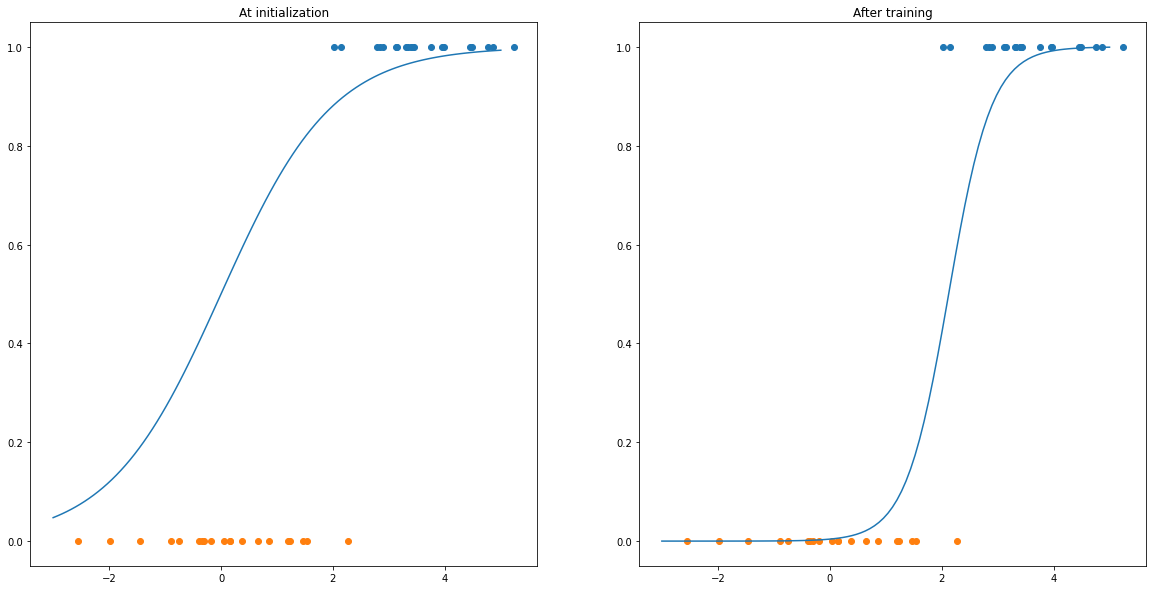

In [30]:
if tf_loaded:
    np.random.seed(0)
    data = np.hstack([
        np.random.normal(3, 1, size=20),
        np.random.normal(0, 1, size=20)
    ])
    labels = np.hstack([ np.ones(20), np.zeros(20) ])
    
    # Defines the model
    class MyModel(tf.keras.Model):
        def __init__(self):
            super().__init__()
            self.b0 = tf.Variable(0., dtype=tf.float32, trainable=True, name='shift')
            self.b1 = tf.Variable(1., dtype=tf.float32, trainable=True, name='slope')
        
        def call(self, inputs):
            # probability of being 1
            return tf.math.sigmoid(self.b0 + inputs * self.b1)
        
    def draw_model(ax, model):
        print(f"predicted shift = {model.b0.numpy()}")
        print(f"predicted slope = {model.b1.numpy()}")
        ax.plot(np.linspace(-3, 5, 100), model(np.linspace(-3, 5, 100)) )
        ax.scatter( data[:20], np.ones(20) )
        ax.scatter( data[20:], np.zeros(20) )
    
    # Creates the model
    model = MyModel()
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))
    draw_model(axs[0], model)
    axs[0].set_title('At initialization')
    
    # Defines the optimization algorithm (SGD is obsolete)
    optimizer =  tf.optimizers.Adam(learning_rate=0.1)
    
    # Steps in the descent
    for step in range(100):
        
        # This library provides automatic derivative using GradientTape
        with tf.GradientTape() as tape:
            probs = model(data)
            loss = tf.losses.categorical_crossentropy(labels, probs)
            
        # computes the derivative and moves the pramameters in correct direction
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    #plt.figure()
    draw_model(axs[1], model)
    axs[1].set_title('After training')

# Task 2
- [1b] Use Logistic Regression to classify the data (X, Y).
- [1b] How many samples the fitted classifier predict as class 1?

In [31]:
# CREATE classifier class
classifier = ???

# Fit the classifier using X - predictors and Y - labels
???

# how many training data will be now classified as class 1 ? 
# DO NOT COUNT THEM, USE predict ;)
???

# Predict all points in [-2, 8] x [-5, 7] plane (to show the resuls)
predictions = classifier.predict(testdata)

# show the results
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_xlim([-2, 8])
ax.set_ylim([-5, 7])
ax.contourf(xspace, yspace, predictions.reshape(xmesh.shape), cmap='jet', alpha=0.3)
ax.scatter(*X[Y==0].T)
ax.scatter(*X[Y==1].T)

SyntaxError: invalid syntax (1482341172.py, line 2)

In [ ]:
predictions = classifier.predict_proba(testdata)[:, 0]
#                        ^ we can predict probabilities using <predict_proba>

# show the results
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_xlim([-2, 8])
ax.set_ylim([-5, 7])
ax.contourf(xspace, yspace, predictions.reshape(xmesh.shape), levels=20, cmap='jet', alpha=0.3)
ax.scatter(*X[Y==0].T)
ax.scatter(*X[Y==1].T)